<a href="https://colab.research.google.com/github/stefanocostantini/pytorch-book/blob/master/ch6_using_a_neural_network_to_fit_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Principles of neural networks

### Neurons

The basic building block is the **neuron**, a simple function. Many neurons combined can approximate more complicated function.

In essence, the neuron is a linear transformation which takes this form

$$
o = f(wx+b)
$$

where $x$ is the input, $w$ is the weight and $b$ is the bias. $w$ and $b$ are the learned parameters. $f$ is the **activation function** and $o$ is the output. $f$ is a non-linear function, like the hyperbolic tangent ($tanh$).

A multilayer network is nothing but a composition of these functions, such as

$$
o = tanh(w_n(... tanh(w_2(tahn(w_{1}x+b_1)+b_2))... + b_n)
$$

### Roles of activation function

It has two main roles:

1. In the inner parts of the model, it allows the output function to have different slopes at different values - something linear functions by definition cannot do. In this way, neural networks can approximate arbitrary functions.
2. At the last layer of the model, it has the role of concentrating the outputs of teh preceding linear operation into a given range

For example, we could have a function that maps outputs over a certain range to just the maximum (or minimum) value of this range. This is the case of `torch.nn.Hardtanh`. `torch.tanh` instead asymptotically approaches -1 and 1, becoming very sensitive to small changes in inputs in the middle, but much less so for extreme cases.

There are several activation functions. `ReLU` (rectified linear unit) is currently considered one of the best-performing general activation functions. `LeakyReLU` modifies the standard `ReLU` to have a msall positive slope, rather than being strictly zero for negative inputs.




### How to choose an activation function

Independently of which function is chosen, these are always:
1. Non linear, which is what allows the network to go beyond the linear method and approximate non-linear functions
2. Differentiable, so that gradients can always be computed through them
3. They have at least one **sensitive range**, this is very useful for training. Many also have an insensitive (or _saturated_) range, where changes to the input results in little of no change to the outputs.

## PyTorch `nn` module

The `torch.nn` module contains all the building blocks needed to create all sorts of neural network architectures.

A PyTorch module is a python class deriving from the `nn.Module` base class. A module can have:
- one or more `Parameter` instances as attributes: these are the tensors whose values we learn during the training process
- one or more submodules (subclasses of `nn.Module`) as attributes, and it will be able to track their parameters as well

One of the subclasses of `nn.Module` is `nn.Linear` which we will use to convert the learning loop from the model in the previous chapter into a neural network.

`nn.Linear` takes three inputs: 
- the number of input features
- the number of output features
- whether there is a bias or not (defaults to `True`)

So in our case - see previous notebook - we have one input (temperature in Celsius), one output (temperature in "unknown" units) and the bias. 

While the model takes in one input, `nn.Module` can take in multiple items at the same time, therefore we **batch** the inputs. The size of the batch is the zero-th dimension in the tensor.

For example, assuming we need to run `nn.Linear` on 10 samples, we can create an input tensor of size _B x Nin_ where _B_ is the size of the batch and _Nin_ is the number of input features. For instance:

In [ ]:
import torch
from torch import nn

x = torch.ones(10, 1)
x.shape

torch.Size([10, 1])

In [ ]:
linear_model = nn.Linear(1, 1)
linear_model(x)
# So it's one input / one output, repeated 10 times in the same batch.

tensor([[-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470],
        [-1.2470]], grad_fn=<AddmmBackward>)

Batching is done to for various reasons.
* A main one is to make sure the computation we're asking for is big enough to saturate the computing resources we're using, i.e. we're exploiting the parallelisation that GPUs make available.
* Some advanced models use statistical information from the entire batch, and those statistics get better with larger batch sizes.

To accommodate batching, we need to modify the dimensions of our data to include that dimension.

In [ ]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_c.shape, t_u.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

In [ ]:
# First let's split the data into training and validation samples
n_samples = t_c.shape[0]
n_val = int(0.2 * n_samples)

random_indices = torch.randperm(n_samples)

train_indices = random_indices[:-n_val]
val_indices = random_indices[-n_val:]

train_indices.shape, val_indices.shape

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train # scaling
t_un_val = 0.1 * t_u_val # scaling

t_un_train.shape, t_c_train.shape, t_un_val.shape, t_c_val.shape

(torch.Size([9, 1]),
 torch.Size([9, 1]),
 torch.Size([2, 1]),
 torch.Size([2, 1]))

Note that the first number is the size of the batch, while the other is the number of input features (in this case just one, for each observation)

We can now we update the training loop, which will not need to change too much. Also, we do not need to define a loss function separately, we just use what is provided by PyTorch.

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
  for epoch in range(1, n_epochs + 1):
    t_p_train = model(t_u_train) # forward pass
    loss_train = loss_fn(t_p_train, t_c_train) # calculate loss

    with torch.no_grad():
      t_p_val = model(t_u_val) # forward pass validation
      loss_val = loss_fn(t_p_val, t_c_val) # calculate validation loss

    optimizer.zero_grad() # reset gradient
    loss_train.backward() # backprop
    optimizer.step() # update model params

    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, train loss: {loss_train}, val loss: {loss_val}.')

In [ ]:
# Now we can train the model
import torch.optim as optim

linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch: 500, train loss: 7.708262920379639, val loss: 28.7823486328125.
Epoch: 1000, train loss: 3.9526824951171875, val loss: 13.717453956604004.
Epoch: 1500, train loss: 3.1364083290100098, val loss: 8.689568519592285.
Epoch: 2000, train loss: 2.958991527557373, val loss: 6.779255390167236.
Epoch: 2500, train loss: 2.9204301834106445, val loss: 5.982912063598633.
Epoch: 3000, train loss: 2.9120466709136963, val loss: 5.63214111328125.


In [ ]:
# The estimated parameters are as follows:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.0213]], requires_grad=True)
Parameter containing:
tensor([-15.9227], requires_grad=True)


Note: the estimates are not exactly the same as in ch5 as we're using a different training / validation split. But they are close. 

Next step is trying to replace the linear model with an actual neural network.

## Using a neural network



We keep everything fixed, including the loss function. All we do is to redefine `model` as a simple neural network: a linear module, followed by an activation function, feeding into another linear module.

The first linear + activation layer is commonly referred to as a __hidden__ layer.

Note: while the input and output of the model are both of size 1 (one input and one output feature), the size of the output of the first linear module is usually larger than 1. There will be different units responding differently to the the inputs, increasing the _capacity_ of the model.

The last linear layer will take the output of activations and combine them linearly to produce the output value

the `nn.Sequential` module allows us to concatenate modules into a single model. We define the following one.

In [ ]:
seq_model = nn.Sequential(
    nn.Linear(1, 13), # this 13 is totally arbitrary
    nn.Tanh(),
    nn.Linear(13, 1) # this 13 needs to match the previous one, i.e. number outputs previous layer = number of inputs this one
    )

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [ ]:
# Let's take a look at the model parameters
for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


These are weight and bias of the two linear layers.

Let's now use this new model in the training loop. Nothing needs to change there.

In [ ]:
optimizer_new = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer_new,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch: 500, train loss: 7.292875289916992, val loss: 68.87445068359375.
Epoch: 1000, train loss: 3.937957763671875, val loss: 36.85575866699219.
Epoch: 1500, train loss: 3.2283828258514404, val loss: 26.302169799804688.
Epoch: 2000, train loss: 2.8077147006988525, val loss: 20.05057716369629.
Epoch: 2500, train loss: 2.5377652645111084, val loss: 15.7839994430542.
Epoch: 3000, train loss: 2.356529712677002, val loss: 12.80571460723877.


Finally we can compare the performance of the linear model with that of the (non-linear) neural network.

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)

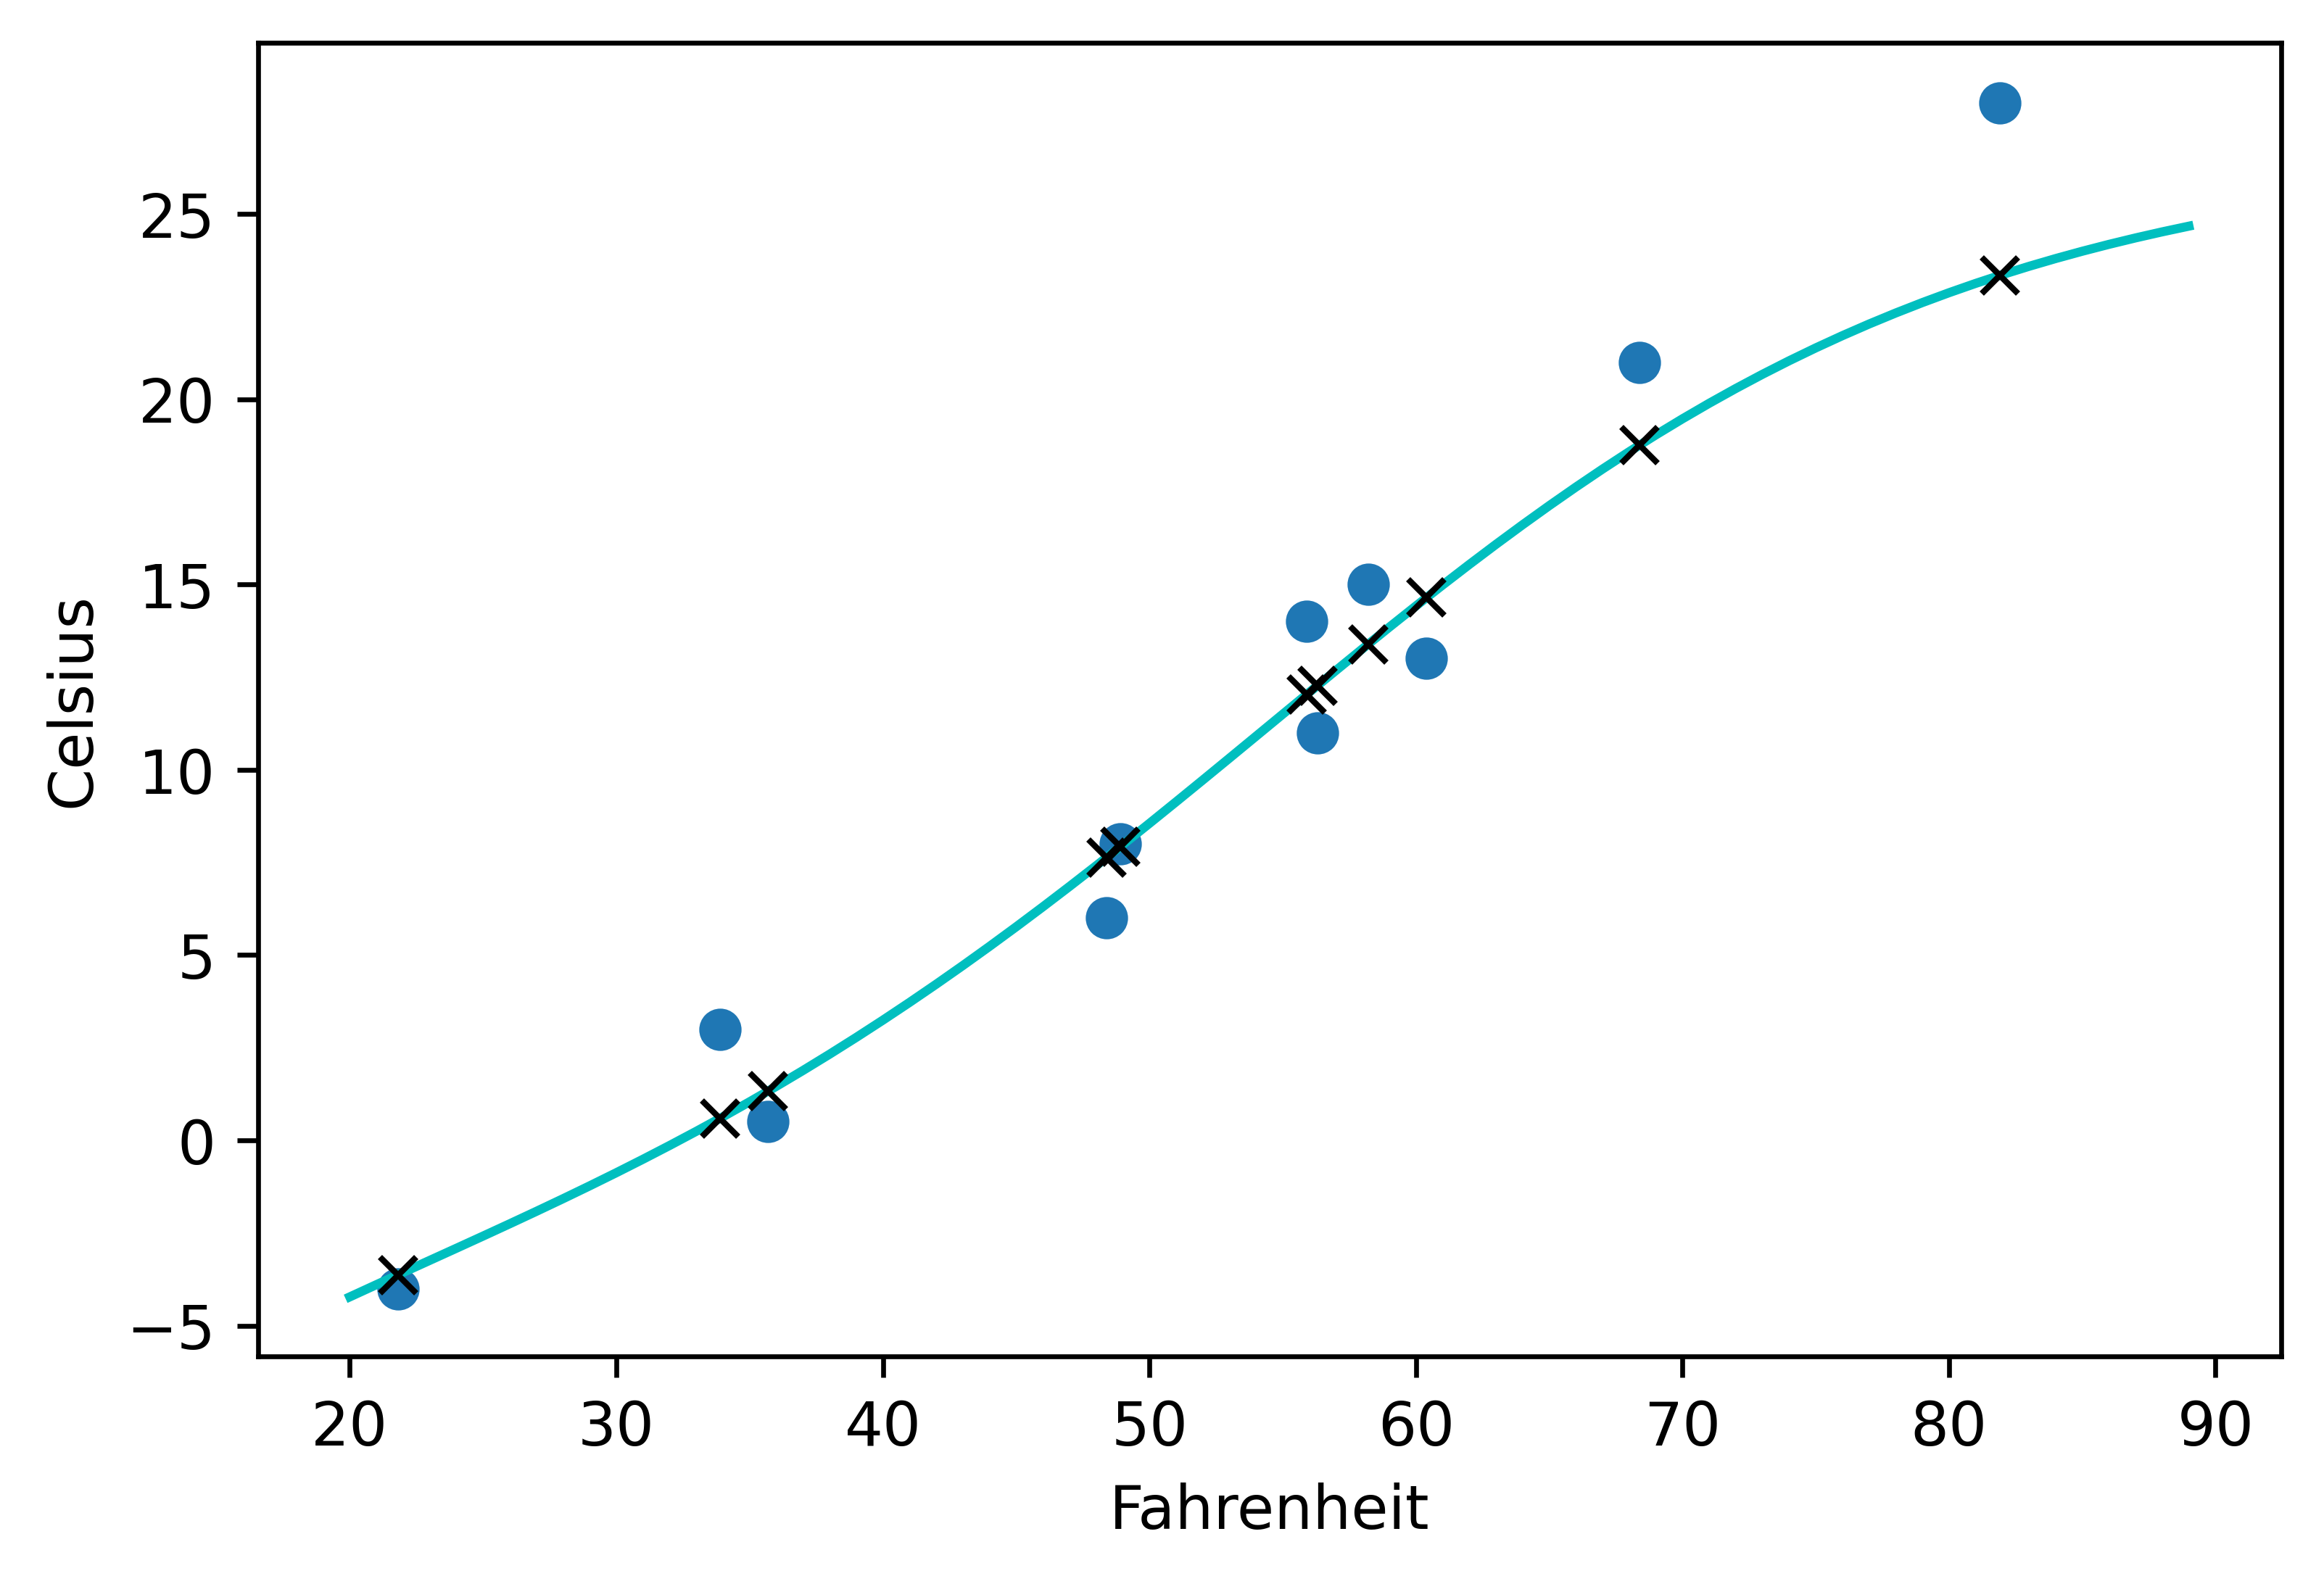

In [ ]:
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

We can see that the trained neural network tends to overfit a bit the data, this is to be expected. Its ability to generalise will probably be lower than the purely linear model, though not much worse. Of course, what is now a disadvantage of the NN, it will be its strength with when trying to approximate very non-linear functions!